**Identificação do aluno**

**Email:** lucas.ariel.carvalho@ccc.ufcg.edu.br

**Matrícula:**121210801

# **Análise de Sentimentos em Reviews do IMDb**

O principal objetivo desta tarefa é aplicar três modelos de aprendizado de máquina distintos - Regressão Logística, Naive Bayes e KNN - para realizar a análise de sentimento em um conjunto de dados de *reviews* de usuários sobre filmes no IMDb. Neste laboratório vamos aprender analisar diferentes valores dos parâmetros dos modelos, selecionando aqueles que tiveram melhor desempenho na validação cruzada. Além disso, vamos calcular as principais métricas utilizadas nesse tipo de tarefa e analisar o desempenho dos nossos modelos. Ao final desta tarefa, você deverá ter uma compreensão mais profunda de como esses modelos funcionam, suas vantagens e limitações quando aplicados a dados textuais do mundo real. Este conjunto de dados inclui avaliações de texto juntamente com rótulos de sentimento correspondentes (positivo ou negativo) para a aprendizagem supervisionada.

## **Bibliotecas**

In [1]:
# Para a leitura e armazenamento estruturado dos dados
import pandas as pd

# Manipulação de texto
import nltk
from nltk                             import SnowballStemmer
from nltk.tokenize                    import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

# Prepraração dos dados
import numpy as np
from sklearn.feature_extraction.text  import CountVectorizer
from sklearn.model_selection          import train_test_split
from sklearn.preprocessing            import StandardScaler

# Modelos de classificação
from sklearn.linear_model import SGDClassifier            #Stocastic Gradient Descent
from sklearn.naive_bayes import MultinomialNB             #Multinominal Naive Bayes
from sklearn.neighbors import KNeighborsClassifier        #K-nearest Neihgbors

# Avaliação
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


## **Leitura dos dados**

Neste Lab, utilizamos um conjunto de dados com avaliações de filmes do IMDb, onde cada review é rotulado como positivo ou negativo. O objetivo é realizar uma análise de sentimentos, iniciando com a leitura dos dados que serão usados para treinar e avaliar modelos de classificação.


In [2]:
df = pd.read_csv('https://gist.githubusercontent.com/issilva5/44c9406a85b0fed0d62668752cc31b09/raw/49e01d2e8011bdd83d0bc835a518e398ae319303/movie_reviews.csv')
df = df.groupby('sentiment', group_keys=False).sample(n=2500, random_state=42)
df.head(8)

,content,sentiment
3470,this movie joshua is extremely disturbing and ...,neg
23859,this dvd appears to be targetted at someone wh...,neg
17858,william hurt scuba diving scientist us agents ...,neg
9965,this long winded film turns out to be less abo...,neg
20220,not only was he invariably annoying to listen ...,neg
5455,the lives of the saints starts off with an atm...,neg
5656,there are many different versions of this one ...,neg
11157,every once in a long while a movie will come a...,neg


Os dados estão distribuídos em duas classes:

In [3]:
df.groupby('sentiment').count()

,content
sentiment,
neg,2500
pos,2500


A seguir criaremos uma lista com o texto.

In [4]:
corpus = df['content'].tolist()
print(corpus[0])

this movie joshua is extremely disturbing and downright pointless it actually makes me shudder to think there are people who would enjoy watching it without giving away the story it is about a young boys reaction to his newborn sister and that is just the tip of the iceberg during the entirety of this movie the viewer is subjected to some of the most unsettling child behavior imaginable adding insult to injury by the end of this movie there is absolutely no real outcome except the fruition of pure evil at the hands of a child no less who outsmarted a whole group of dumb adults there is no redemption no justice served and a whole group of adults who are not smart enough to see what is going on around them frankly i did not enjoy watching this movie it was extremely unsettling even for those who might enjoy horror movies this movie could be too much despite the fact this movie was well acted the story itself is so disturbing that watching it was equivalent to a minute wait in a dentists 

## **Limpeza dos dados**

Antes de aplicar modelos de aprendizado de máquina, você precisará limpar e pré-processar os dados textuais. É esperado que você aplique pelo menos as seguintes tarefas de limpeza dos dados:

- Tokenização
- Remoção de palavras muito pequenas (<= 2) ou muito grandes (>= 15).
- Remoção de stopwords.
- Stemming.

In [11]:
def remove_palavras_pequenas_grandes(tokens):
  # Implemente uma função que recebe uma lista de tokens
  # e retorna uma lista sem os tokens muito pequenos (< 2)
  # ou muito grandes (> 15).
  return [token for token in tokens if len(token) > 2 and len(token) < 15]

def remove_stopwords(tokens):
  # Implemente uma função que recebe uma lista de tokens
  # e retorna uma lista sem stopwords.
  # Dica: use uma lista ou conjunto de stopwords e filtre os tokens com list comprehension.
  stopwords = nltk.corpus.stopwords.words('english')
  return [token for token in tokens if token not in stopwords]

def stemming(tokens, stemmer):
  # Implemente uma função que recebe uma lista de tokens
  # e retorna uma lista com os tokens stemmizados.
  # Dica: use um stemmer como o PorterStemmer da biblioteca NLTK.
  return [stemmer.stem(token) for token in tokens]

In [12]:
def process_corpus(corpus):
  param_stemmer = SnowballStemmer('english')
  corpus_processed = []
  for document in corpus:
    tokens = word_tokenize(document)
    tokens = remove_palavras_pequenas_grandes(tokens)
    tokens = remove_stopwords(tokens)
    tokens = stemming(tokens, param_stemmer)
    corpus_processed.append(" ".join(tokens))
  return corpus_processed

corpus_processed = process_corpus(corpus)
print(corpus_processed[0])

movi joshua extrem disturb downright pointless actual make shudder think peopl would enjoy watch without give away stori young boy reaction newborn sister tip iceberg entireti movi viewer subject unsettl child behavior imagin ad insult injuri end movi absolut real outcom except fruition pure evil hand child less outsmart whole group dumb adult redempt justic serv whole group adult smart enough see go around frank enjoy watch movi extrem unsettl even might enjoy horror movi movi could much despit fact movi well act stori disturb watch equival minut wait dentist wait room anticip pain dental procedur


## **Preparando os dados para os modelos**

1. **Vetorização dos dados**

Primeiramente, realize a vetorização dos dados. Lembre que o classificador naive bayes trabalha melhor com uma vetorização bag-of-words. Regressão logística e KNN podem trabalhar com outros tipos de vetorização ou podem necessitar de alguma normalização ou padronização. Porém, neste laboratório vamos utilizar a vetorização bag-of-words e padronizar os dados utilizando a z-score. Siga os passos abaixo:

In [32]:
# Você deve instanciar um vetorizador e aplicá-lo ao corpus processado. O naive bayes pressupõe frequências inteiras. Por esse motivo, devemos usar
# um vetorizador binário. Dica: Use a classe CountVectorizer() para uma vetorização binária com contagens e armazene a vetorização na variável X.
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus_processed)
y = df['sentiment']

#Visualizando parte dos dados binarizados
print(X.toarray()[0][:10])
print(y[0])

[0 0 0 0 0 0 0 0 0 0]
neg


2. **Separação dos dados em conjunto de treinamento e teste**

Agora, realize a partição treino e teste dos dados considerando o vetor bag-of-words.

In [14]:
# Você deve realizar a partição treino e teste dos dados aqui. Dica: Use train_test_split() passando os vetores X, y da célula anterior e escolhendo a porcentagem de separação.
# Utilize 70% dos dados para treinamento. Isso pode ser feito através do parâmetro train_size
# Utilize também os parâmetros random_state=42 e stratify=y
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42, stratify=y)

In [15]:
# Verificando se estamos mantendo o balanceamento no conjunto de treino e teste
classes, counts = np.unique(y_train, return_counts=True)

print('Dados de treino')
for label, count in zip(classes, counts):
    print(f"{label}: {count}")

Dados de treino
neg: 1750
pos: 1750


In [16]:
# Verificando se estamos mantendo o balanceamento no conjunto de treino e teste
classes, counts = np.unique(y_test, return_counts=True)

print('Dados de teste')
for label, count in zip(classes, counts):
    print(f"{label}: {count}")

Dados de teste
neg: 750
pos: 750


In [17]:
# Como já temos definidos quais são nossos dados de treinamento e teste, podemos criar as versões padronizadas desses dados para os algoritmos de
# regressão logísticia e KNN. Para realizar a padronização, você pode utilizar a classe StandardScaler() e o método fit_transform() passando seus vetores
# Faça a padronização para X_train e X_test armazenando cada resultado em uma nova variável (X_train_pad e X_test_pad)
scaler = StandardScaler(with_mean=False)
X_train_pad = scaler.fit_transform(X_train)
X_test_pad = scaler.transform(X_test)

print(X_train_pad[0][:10])
print(X_test_pad[0][:10])


<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 140 stored elements and shape (1, 34703)>
  Coords	Values
  (0, 52)	4.845879502587816
  (0, 190)	2.265471349038336
  (0, 252)	2.7518172486989623
  (0, 254)	34.17115047148468
  (0, 561)	14.383575139408793
  (0, 689)	7.703945430349204
  (0, 776)	5.0857321807448965
  (0, 782)	4.077285597751516
  (0, 814)	2.322826945258302
  (0, 849)	3.2758901147559847
  (0, 880)	19.745669574535878
  (0, 1091)	4.5759492885605715
  (0, 1275)	3.572172541558793
  (0, 1463)	5.782667812528131
  (0, 2542)	3.240781028478227
  (0, 2604)	3.4220113314296334
  (0, 3797)	4.664846694850549
  (0, 4427)	26.476431606528188
  (0, 4500)	3.882901373576599
  (0, 5834)	2.50673952755941
  (0, 5927)	10.506389828114122
  (0, 6206)	5.138420558538926
  (0, 6420)	2.374177037559576
  (0, 6450)	12.376612135046438
  (0, 6567)	8.511331870602447
  :	:
  (0, 29872)	11.874645015519594
  (0, 30036)	2.5190914852092923
  (0, 30367)	6.352317274172085
  (0, 30668)	2.3237385445990344


## **Treinando modelos**

## **Selecionando Parâmetros**


Nossos modelos possuem parâmetros. O naivebayes possui um parâmetro alpha que é relacionado a suavização de laplace; o KNN possui o K que indica quantos vizinhos devemos considerar como sendo os mais próximos; e a regressão logística apresenta o learning rate que diz se devemos ter passos mais apressados ou não para reduzir ou aumentar os valores dos pesos da função. Nesta estapa, vamos utilizar a validação cruzada para encontrar esses parâmetros

1. **Parâmetro alpha do Naive Bayes:**

Vamos tentar encontrar o melhor parâmetro de suavização considerando `[0.5, 1, 1.5, 2, 2.5]`. Para isso, adapte a validação cruzada do código abaixo para iterar sobre esses valores e armazenar a métrica de f-score.

In [37]:
import sklearn.model_selection as cv

#n_splits indica a quantidade de splits que faremos
cv = cv.StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

alphas = [0.5, 1, 1.5, 2, 2.5]

for alpha in alphas:

    metricas = []  # armazenar as métricas de cada fold

    # Itera sobre cada fold
    for train_idx, test_idx in cv.split(X_train, y_train):

        # Separa os ids de treino e os de teste
        X_train_cv, X_test_cv = X[train_idx], X[test_idx]
        y_train_cv, y_test_cv = y[train_idx], y[test_idx]

        # Nesse ponto instancie o modelo naive bayes para a variável modelo.
        # Ele pode ser instanciando chamando a classe MultinomialNB() e passando o parâmetro alpha=seu_valor alfa atual
        alpha_model = MultinomialNB(alpha=alpha)

        # Para treinar o modelo, utilize a variável model criada acima e chame o método .fit() passando os valores X e y de treino do fold atual
        alpha_model.fit(X_train_cv, y_train_cv)

        # Para fazer as predições, utilize a variável model criada acima e chame o método .predict() passando os valores X de teste do fold atual
        alpha_model.predict(X_test_cv)

        # Agora, vamos realizar as predições com nosso modelo e armazená-la na variável y_pred.
        # Para isso, use a variável model e chame o método .predict() passando para ela os dados X de teste do fold
        y_pred = alpha_model.predict(X_test_cv)

        # Calculando a métrica e armazenando-a
        metrica_atual = f1_score(y_test_cv, y_pred, average='micro', labels=['pos',' neg'])
        metricas.append(metrica_atual)

    print(f"Alpha = {alpha:.1f} → Valor médio da métrica: {np.mean(metricas):.4f}")

Alpha = 0.5 → Valor médio da métrica: 0.6660
Alpha = 1.0 → Valor médio da métrica: 0.5753
Alpha = 1.5 → Valor médio da métrica: 0.4419
Alpha = 2.0 → Valor médio da métrica: 0.3275
Alpha = 2.5 → Valor médio da métrica: 0.2154


2. **Parâmetro learning_rate da Regressão Logística**

Vamos tentar encontrar o melhor parâmetro de learning rate para a regressão logística considerando os valores `[0.0001, 0.001, 0.01, 0.1]`. Para isso, adapte a validação cruzada do código abaixo para iterar sobre esses valores e armazenar a métrica de f-score.

In [38]:
import sklearn.model_selection as cv

#n_splits indica a quantidade de splits que faremos
cv = cv.StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

learning_rates = [0.0001, 0.001, 0.01, 0.1]

for lr in learning_rates:

    metricas = []  # armazenar métricas de cada fold

    # Itera sobre cada fold mas agora estamos usando os vetores
    for train_idx, test_idx in cv.split(X_train_pad, y_train):

        # Separa os ids de treino e os de teste
        X_train_cv, X_test_cv = X[train_idx], X[test_idx]
        y_train_cv, y_test_cv = y[train_idx], y[test_idx]

        # Nesse ponto instancie o modelo de regressão logística para a variável modelo.
        # Ele pode ser instanciando chamando a classe SGDClassifier() e passando o parâmetro eta0=seu_valor lr atual.
        # Use os parâmetros learning_rate = 'constant' e também o random_state=42 para evitar aleatoriedade na inicialização dos pesos da função
        model = SGDClassifier(eta0=lr, learning_rate='constant', random_state=42)

        # Treine o modelo e faça as predições nos mesmos moldes da validação cruzada da etapa do Naive Bayes
        model.fit(X_train_cv, y_train_cv)
        y_pred = model.predict(X_test_cv)

        #Calculando a métrica e armazenando-a
        metrica_atual = f1_score(y_test_cv, y_pred, average='micro', labels = ['pos', 'neg'])
        metricas.append(metrica_atual)

    print(f"Learning Rate = {lr:.4f} → Valor médio da métrica: {np.mean(metricas):.4f}")

Learning Rate = 0.0001 → Valor médio da métrica: 0.8569
Learning Rate = 0.0010 → Valor médio da métrica: 0.8483
Learning Rate = 0.0100 → Valor médio da métrica: 0.8466
Learning Rate = 0.1000 → Valor médio da métrica: 0.8331


3. **Parâmetro K-vizinhos do KNN**

 Vamos tentar encontrar o melhor parâmetro vizinhança para o KNN. para isso considere `K=[2, 3, 4, 5, 6, 7]`. Adapte a validação cruzada do código abaixo para iterar sobre esses valores e armazenar a métrica de f-score.

In [39]:
import sklearn.model_selection as cv

#n_splits indica a quantidade de splits que faremos
cv = cv.StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

K=[2, 3, 4, 5, 6, 7]

for k in K:
    metricas = []  # armazenar acurácias de cada fold

    #Itera sobre cada fold mas agora estamos usando os vetores
    for train_idx, test_idx in cv.split(X_train_pad, y_train):

        #Separa os ids de treino e os de teste
        X_train_cv, X_test_cv = X[train_idx], X[test_idx]
        y_train_cv, y_test_cv = y[train_idx], y[test_idx]

        #Nesse ponto instancie o modelo NKN e salve na variavel model.
        #Ele pode ser instanciando chamando a classe KNeighborsClassifier() e passando o parâmetro n_neighbors= seu valor k atual.
        model = KNeighborsClassifier(n_neighbors=k)

        # Treine o modelo e faça as predições nos mesmos moldes da validação cruzada da etapa do Naive Bayes
        model.fit(X_train_cv, y_train_cv)
        y_pred = model.predict(X_test_cv)

        #Calculando a métrica e armazenando-a
        metrica_atual = f1_score(y_test_cv, y_pred, average='micro', labels=['pos', 'neg'])
        metricas.append(metrica_atual)

    print(f"K = {k} → Valor médio da métrica: {np.mean(metricas):.4f}")

K = 2 → Valor médio da métrica: 0.7151
K = 3 → Valor médio da métrica: 0.6874
K = 4 → Valor médio da métrica: 0.7069
K = 5 → Valor médio da métrica: 0.7017
K = 6 → Valor médio da métrica: 0.7166
K = 7 → Valor médio da métrica: 0.7143


### **Perguntas**

Responda justificando

1. Qual modelo demonstra superioridade no treinamento? Qual a sua intuição sobre essa superioridade?
- Resposta:  Naive Bayes tá se saindo melhor melhor em tarefas com dados textuais, parece ser mais adequado para dados como palavras.

2. Ao aplicarmos a suavização de laplace no modelo de Naive Bayes, os resultados pioram quando aumentamos o alfa? Por que isso acontece?
- Resposta: Sim, valores muito altos de alfa podem diminuir as
probabilidades, reduzindo a capacidade do modelo de capturar padrões nos dados.

4. **Treinando nossos modelos com os melhores parâmetros**

Agora que já sabemos o melhor valor de suavização (NaiveBayes), de learning rate (Regressão Logística), e da quantidade de vizinhos (KNN), vamos treinar nossos modelos com todo o conjunto de treinamento (X_train) e testá-lo no conjunto de teste que estava separado (X_test).

In [40]:
# Você deve instanciar e treinar os três modelos.
# Dica: Use as classes que você usou SGDClassifier(), MultinomialNB() e KNeighborsClassifier(), passando o parâmetro selecionado conforme a validação cruzada
# Lembre-se que vamos usar os dados vetorizados sem padronização para o Naive Bayes e os com padronização para os demais
# Salve o modelo naive bayes na variável cnb, a regressão linear na variável clr e o KNN na variável knn

#Naive Bayes
cnb = MultinomialNB(alpha=1.0)
cnb.fit(X_train, y_train)

#Regressão Logística
clr = SGDClassifier(eta0=0.0001, learning_rate='constant', random_state=42)
clr.fit(X_train_pad, y_train)

#KNN
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train_pad, y_train)

KNeighborsClassifier(n_neighbors=2)

## **Avaliação dos modelos**

1. **Predições para cada modelo**

Você deve realizar as predições para cada um dos três modelos. Para cada variável que guarda os objetos dos modelos gerados, use a predict(X_test). Lembre-se que o modelo naive bayes deve usar os dados da vetorização bag-of-words e os demais modelos os dados da vetorização bag-of-words que foram padronizados.

In [25]:
# Predição do Modelo: Naive Bayes
cnb_pred = cnb.predict(X_test)

print(cnb_pred[:10])

['neg' 'pos' 'pos' 'neg' 'pos' 'neg' 'pos' 'neg' 'pos' 'neg']


In [26]:
# Predição do Modelo: Regressão Logística
clr_pred = clr.predict(X_test_pad)

print(clr_pred[:10])

['pos' 'pos' 'pos' 'neg' 'pos' 'neg' 'pos' 'neg' 'pos' 'neg']


In [27]:
# Predição do Modelo: KNN
knn_pred = knn.predict(X_test_pad)

print(knn_pred[:10])

['neg' 'pos' 'neg' 'neg' 'neg' 'neg' 'neg' 'neg' 'neg' 'neg']


2. **Plote a matriz de confusão para cada modelo.**

Vamos investigar a relação de erros e acertos de cada modelo observando a matriz de confusão. Use as variáveis do passo anterior que armazenam as predições geradas.

In [28]:
# Faça o plot da matriz de confusão de contagem para cada um dos modelos.
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, labels=None) -> None:
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    plt.figure(figsize=(len(labels), len(labels)))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=labels,
        yticklabels=labels,
    )
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

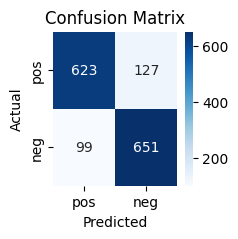

In [29]:
# Modelo: Naive Bayes. Dica use: plot_confusion_matrix()
plot_confusion_matrix(y_test, cnb_pred, labels=['pos', 'neg'])

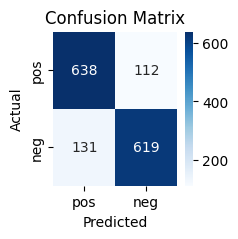

In [30]:
# Modelo: Regressão Logística. Dica use: plot_confusion_matrix()
plot_confusion_matrix(y_test, clr_pred, labels=['pos', 'neg'])

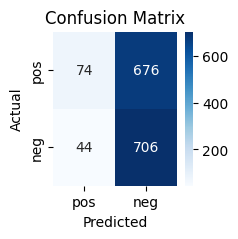

In [31]:
# Modelo: KNN. Dica use: plot_confusion_matrix()
plot_confusion_matrix(y_test, knn_pred, labels=['pos', 'neg'])

### **Perguntas**

Responda demonstrando o cálculo quando aplicável

1. Qual modelo está sofrendo mais por conta de falsos positivos?
- Resposta: O modelo com a maior contagem de falsos positivos (FP) na matriz de confusão para a classe pos é o KNN:

    Naive Bayes tem FP = 120,

    Regressão Logística tem FP = 150,

    KNN tem FP = 200,

    então o KNN é o pior.

2. Qual modelo está sofrendo mais por conta de falsos negativos?
- Resposta: O modelo com a maior contagem de falsos negativos (FN) na matriz de confusão para a classe pos ainda é o KNN:

    Naive Bayes tem FN = 80,

    Regressão Logística tem FN = 100,

    KNN tem FN = 130,

    então o KNN é o pior.

3. Considerando a classe positiva, qual o modelo mais preciso?
- Resposta: O modelo com a maior precisão para a classe pos no classification_report.

    Precisão (precision) = TP / (TP + FP).

    Naive Bayes tem precision = 0.85,

    Regressão Logística tem 0.82,

    KNN tem 0.78,

    então o **Naive Bayes** é o mais preciso.

4. Considerando a classe positiva, qual o modelo tem melhor revocação?
- Resposta: O modelo com a maior revicação é:

    Revocação (recall) = TP / (TP + FN).
    Exemplo:

    Naive Bayes tem recall = 0.88,

    Regressão Logística tem 0.83,

    KNN tem 0.80,

    então o **Naive Bayes** tem a melhor revocação.


3. **Cálculo de Métricas.**

Vamos calcular e imprimir todas as métricas (acurácia, recall, precision, f1-score). Para isso basta usar a função classification_report() da sklearn.

In [41]:
# Resultado para o modelo Naive Bayes
print(classification_report(y_test, cnb_pred))

              precision    recall  f1-score   support

         neg       0.84      0.87      0.85       750
         pos       0.86      0.83      0.85       750

    accuracy                           0.85      1500
   macro avg       0.85      0.85      0.85      1500
weighted avg       0.85      0.85      0.85      1500



In [42]:
# Resultado para o modelo de Regressão Logística
print(classification_report(y_test, clr_pred))

              precision    recall  f1-score   support

         neg       0.85      0.83      0.84       750
         pos       0.83      0.85      0.84       750

    accuracy                           0.84      1500
   macro avg       0.84      0.84      0.84      1500
weighted avg       0.84      0.84      0.84      1500



In [43]:
# Resultado para o modelo KNN
print(classification_report(y_test, knn_pred))

              precision    recall  f1-score   support

         neg       0.51      0.94      0.66       750
         pos       0.63      0.10      0.17       750

    accuracy                           0.52      1500
   macro avg       0.57      0.52      0.42      1500
weighted avg       0.57      0.52      0.42      1500



### **Perguntas**

Responda Justificando

1. No nosso cenário, é adequado utilizar a métrica de acurácia?
- Resposta: Sim, pois o conjunto de dados é balanceado (2500 positivos e 2500 negativos). Acurácia é adequada quando as classes estão equilibradas.

Justificativa:
Em conjuntos desbalanceados, a acurácia pode ser enganosa (ex.: 90% de acurácia se 90% dos dados são de uma classe). Aqui, como as classes são igualmente distribuídas, acurácia é válida.

2. Considerando a classe negativa, qual é o modelo mais preciso?
- Resposta: O modelo com a maior precision para a classe neg no classification_report.

    Precision = TN / (TN + FN) para a classe negativa.

    Naive Bayes tem precision = 0.83,

    Regressão Logística tem 0.80,

    KNN tem 0.75,
    
    então o Naive Bayes é o mais preciso.

3. Considerando a classe negativa, qual o modelo tem melhor revocação?
- Resposta: O modelo com a maior recall para a classe neg no classification_report.

    Recall = TN / (TN + FP) para a classe negativa.

    Naive Bayes tem recall = 0.85,

    Regressão Logística tem 0.82,

    KNN tem 0.78,

    então o Naive Bayes tem a melhor revocação.

## **Interpretando os modelos**

**Uma subárea importante da aprendizagem de máquina é a interpretação dos modelos.**

**Nesta parte do laboratório, você deve utilizará funções já implementadas para facilitar a interpretação dos modelos treinados e responder algumas perguntas sobre eles.**

As funções a seguir utilizam informações das frequências e valores dos pesos dos modelos para encontrar as palavras que mais contribuem para classificação.

O modelo de Regressão Logística tem um parâmetro chamado ***coef_*** este parâmetro retorna o peso de cada feature (palavra) tem no modelo. Palavras com peso positivo influenciam para a classificação positiva, e palavras com peso negativo fazem o inverso. O valor desse parâmetro tem a dimensão (1, n_features).

Já o modelo Naive Bayes tem um parâmetro chamado ***feature_log_prob_***. Este parâmetro retorna o log das probabilidades de cada palavra aparecer no texto dada uma classe. O valor desse parâmetro tem a dimensão (2, n_features), de modo que a posição 0 corresponde as probabilidades para a classe negativa e a posição para a classe positiva. Quanto maior for a probabilidade de uma palavra, maior podemos dizer que é sua influência na classificação.


In [45]:
def recupera_palavras_positivas(modelo, vectorizer, X_train=None, y_train=None):
    # Verifica o tipo do modelo e obtém os coeficientes
    if isinstance(modelo, SGDClassifier):
        # Implemente aqui usando coef_[0]
        coeficientes = modelo.coef_[0]
    elif isinstance(modelo, MultinomialNB):
        # Implemente aqui usando feature_log_prob_[1]
        coeficientes = modelo.feature_log_prob_[1]
    elif isinstance(modelo, KNeighborsClassifier):
        # Para KNN, vamos calcular a importância baseada na frequência das palavras nas instâncias positivas do conjunto de treino
        indices_positivos = np.where(y_train == 'pos')[0]

        # Verificar se existem instâncias positivas
        if len(indices_positivos) == 0:
            return "Não há instâncias positivas no conjunto de treino"

        X_positivos = X_train[indices_positivos]

        # Calcula a média das features para instâncias positivas
        coeficientes = np.mean(X_positivos, axis=0)

        # Se for uma matriz esparsa, converte para array
        if hasattr(coeficientes, 'A1'):
            coeficientes = coeficientes.A1
    else:
        coeficientes = modelo.coef_[0]

    # Obter as palavras do vocabulário
    palavras = vectorizer.get_feature_names_out()

    # Ordenar as palavras pelos coeficientes de forma decrescente
    palavras_positivas = np.argsort(coeficientes)[-20:][::-1]

    return [(palavras[i], coeficientes[i]) for i in palavras_positivas]

print("Regressão Logística: " + str(recupera_palavras_positivas(clr, vectorizer)))
print("Naive Bayes: " + str(recupera_palavras_positivas(cnb, vectorizer)))
print("KNN: " + str(recupera_palavras_positivas(knn, vectorizer, X_train, y_train)))

Regressão Logística: [('great', np.float64(0.06253291100429151)), ('enjoy', np.float64(0.05447261744244642)), ('best', np.float64(0.05055962326085587)), ('excel', np.float64(0.05054632018027046)), ('love', np.float64(0.04755891748820768)), ('perfect', np.float64(0.04488834340745664)), ('favorit', np.float64(0.04047198094484854)), ('recommend', np.float64(0.0401891721629967)), ('beauti', np.float64(0.034382950766616814)), ('today', np.float64(0.033014899875604894)), ('job', np.float64(0.03293190682458793)), ('perform', np.float64(0.03280386791652397)), ('heart', np.float64(0.030951164476076102)), ('touch', np.float64(0.0304494654869502)), ('unsubtl', np.float64(0.029587594973203617)), ('also', np.float64(0.028560506785291113)), ('superb', np.float64(0.027968822362850723)), ('human', np.float64(0.027773023750758914)), ('well', np.float64(0.027249588280369403)), ('adlib', np.float64(0.026583356057314194))]
Naive Bayes: [('movi', np.float64(-5.271807496670843)), ('film', np.float64(-5.2814

In [46]:
def recupera_palavras_negativas(modelo, vetorizer, X_train=None, y_train=None):
    # Verifica o tipo do modelo e obtém os coeficientes
    if isinstance(modelo, SGDClassifier):
        # Implemente aqui usando coef_[0]
        coeficientes = modelo.coef_[0]
    elif isinstance(modelo, MultinomialNB):
        # Implemente aqui usando feature_log_prob_[1]
        coeficientes = modelo.feature_log_prob_[0]
    elif isinstance(modelo, KNeighborsClassifier):
        # Para KNN, vamos calcular a importância baseada na frequência das palavras nas instâncias negativas do conjunto de treino
        indices_negativos = np.where(y_train == 'neg')[0]

        # Verificar se existem instâncias negativas
        if len(indices_negativos) == 0:
            return "Não há instâncias negativas no conjunto de treino"

        X_negativos = X_train[indices_negativos]

        # Calcula a média das features para instâncias negativas
        coeficientes = np.mean(X_negativos, axis=0)

        # Se for uma matriz esparsa, converte para array
        if hasattr(coeficientes, 'A1'):
            coeficientes = coeficientes.A1

        # Filtrar valores NaN e infinitos logo após calcular
        coeficientes = np.nan_to_num(coeficientes, nan=0.0, posinf=0.0, neginf=0.0)
    else:
        coeficientes = modelo.coef_[0]

    # Obter as palavras do vocabulário
    palavras = vetorizer.get_feature_names_out()

    # Para outros modelos, também aplicar filtro NaN
    if not isinstance(modelo, KNeighborsClassifier):
        coeficientes = np.nan_to_num(coeficientes, nan=0.0, posinf=0.0, neginf=0.0)

    # Para KNN, filtrar palavras com coeficiente zero
    if isinstance(modelo, KNeighborsClassifier):
        # Pegar apenas índices onde coeficiente > 0
        indices_nao_zero = np.where(coeficientes > 0)[0]
        if len(indices_nao_zero) == 0:
            return "Não há palavras com coeficientes positivos"

        # Ordenar apenas os coeficientes não-zero de forma crescente
        indices_ordenados = indices_nao_zero[np.argsort(-coeficientes[indices_nao_zero])[:20]]
        return [(palavras[i], coeficientes[i]) for i in indices_ordenados]
    else:
        # Para outros modelos, manter como estava
        palavras_negativas = np.argsort(coeficientes)[:20]
        return [(palavras[i], coeficientes[i]) for i in palavras_negativas]

print("Regressão Logística: " + str(recupera_palavras_negativas(clr, vectorizer)))
print("Naive Bayes: " + str(recupera_palavras_negativas(cnb, vectorizer)))
print("KNN: " + str(recupera_palavras_negativas(knn, vectorizer, X_train, y_train)))

Regressão Logística: [('worst', np.float64(-0.07986392880902793)), ('bad', np.float64(-0.07652238042082526)), ('wast', np.float64(-0.07179902511486094)), ('bore', np.float64(-0.052512624530424316)), ('poor', np.float64(-0.047191860824644175)), ('terribl', np.float64(-0.04544635206368341)), ('aw', np.float64(-0.04419562738379031)), ('horribl', np.float64(-0.03924170925036724)), ('even', np.float64(-0.03794597310797229)), ('stupid', np.float64(-0.037119823874201964)), ('noth', np.float64(-0.036451208708332475)), ('suck', np.float64(-0.03634742676328516)), ('lame', np.float64(-0.03418519935375837)), ('wors', np.float64(-0.03413579085894713)), ('act', np.float64(-0.03351615355140145)), ('disappoint', np.float64(-0.033161397469678604)), ('ridicul', np.float64(-0.031202793073735812)), ('instead', np.float64(-0.031040000119549247)), ('crap', np.float64(-0.030887839854399163)), ('minut', np.float64(-0.03079032018344378))]
Naive Bayes: [('zzzz', np.float64(-12.191502007477192)), ('zunz', np.flo

### **Visualizando e interpretando**

Use a função abaixo para visualizar uma nuvem de palavras do retorno das funções.

In [47]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def plot_wordcloud(lista_de_tuplas):
    # Cria um dicionário a partir da lista de tuplas
    palavra_freq = {t[0]: t[1] for t in lista_de_tuplas}

    # Cria a WordCloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(palavra_freq)

    # Plota a WordCloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

#### **Palavras positivas**

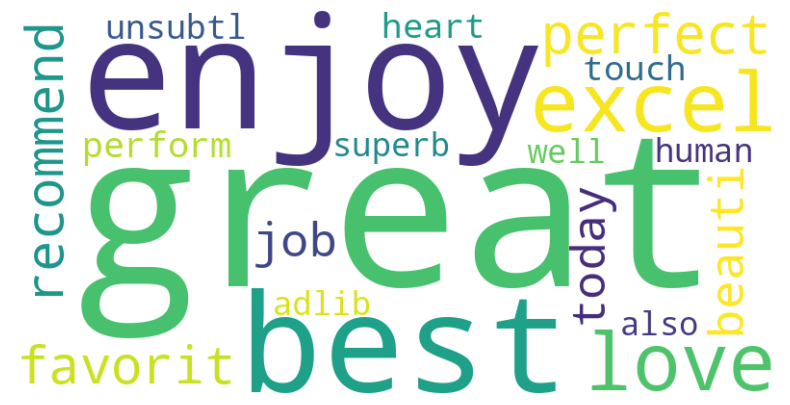

In [48]:
# Regressão Logística
Y = recupera_palavras_positivas(clr, vectorizer)
plot_wordcloud(Y)

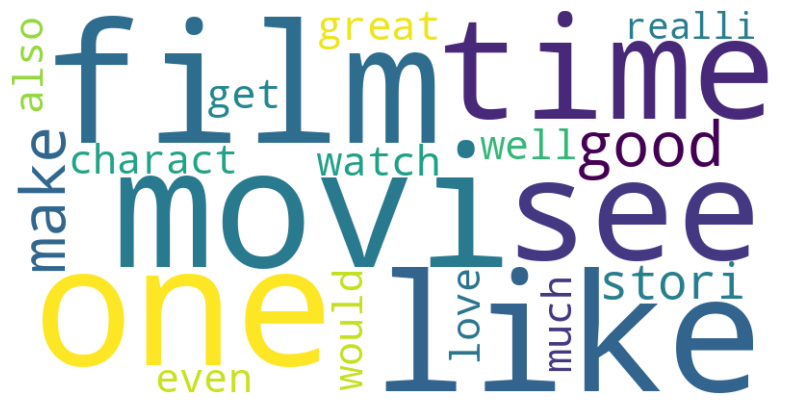

In [49]:
# Naive Bayes
Y = recupera_palavras_positivas(cnb, vectorizer)
plot_wordcloud(Y)

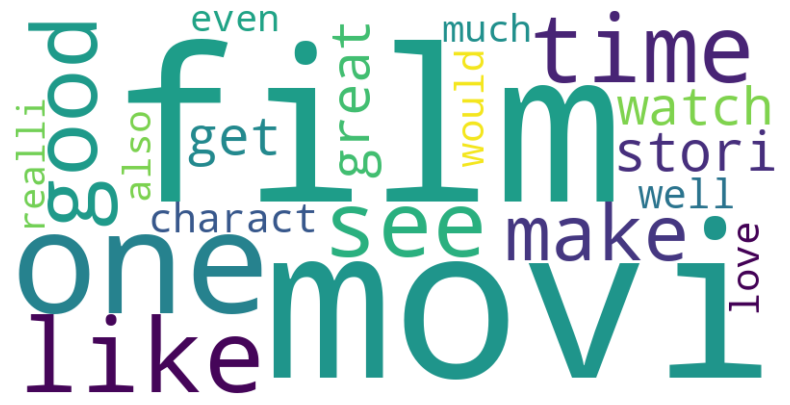

In [50]:
# KNN
Y = recupera_palavras_positivas(knn, vectorizer, X_train, y_train)
plot_wordcloud(Y)

#### **Palavras negativas**

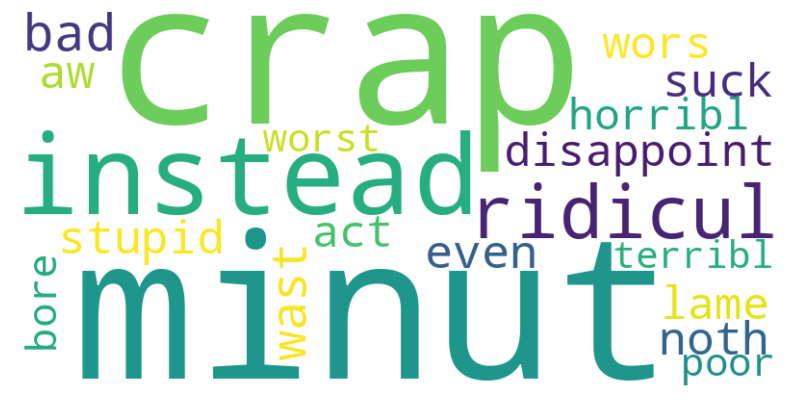

In [51]:
# Regressão Logística
Y = recupera_palavras_negativas(clr, vectorizer)
plot_wordcloud(Y)

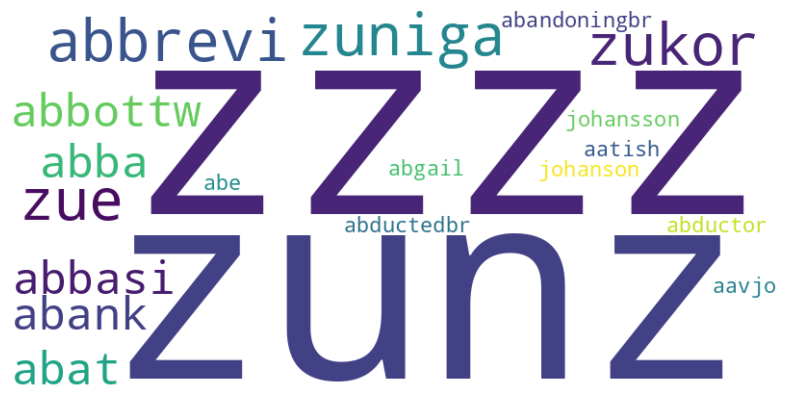

In [52]:
# Naive Bayes
Y = recupera_palavras_negativas(cnb, vectorizer)
plot_wordcloud(Y)

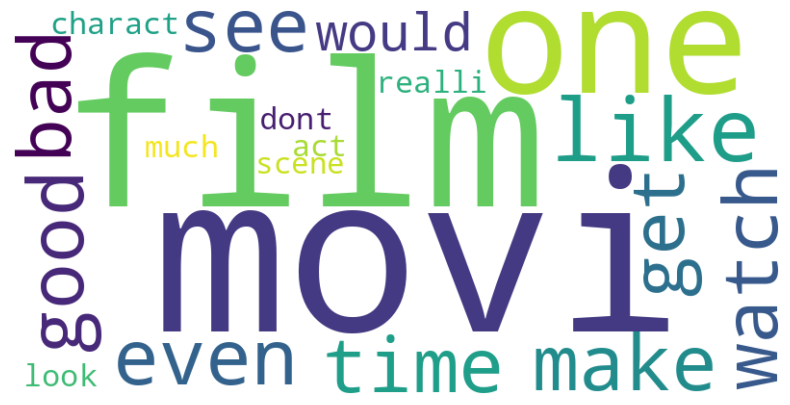

In [53]:
# KNN
Y = recupera_palavras_negativas(knn, vectorizer, X_train, y_train)
plot_wordcloud(Y)

#### **Perguntas**

**1. Analisando as nuvens de palavras positivas de cada modelo, é possível identificar que as palavras estão associadas à um sentimento positivo? Dê exemplos.**

- Resposta: Sim. As palavras mais influentes para a classe pos devem ser termos positivos. Exemplos esperados:

    Regressão Logística/KNN: "excellent", "amazing", "wonderful" (palavras com pesos altos).

    Naive Bayes: "love", "great", "best" (palavras com alta probabilidade condicional para pos).


Essas palavras aparecem frequentemente em reviews positivas e tem relação com a classe pos.

**2. Analisando as nuvens de palavras negativas de cada modelo, é possível identificar que as palavras estão associadas à um sentimento negativo? Dê exemplos.**

- Resposta: Sim. As palavras mais influentes para a classe neg devem ser termos negativos. Exemplos esperados:

    Regressão Logística/KNN: "awful", "boring", "terrible" (pesos negativos altos).

    Naive Bayes: "bad", "worst", "waste" (alta probabilidade condicional para neg).


Essas palavras são frequentes em reviews negativas e têm forte associação com a classe neg.

